<p> This notebook seeks to translate the R code of Julian J. Faraway (2016): <b>Extending the Linear Model with R:</b> Generalized Linear, Mixed Effects and Nonparametric Regression Models. Second Edition. CRC Press, Talor & Francis Group (A CHAPMAN & HALL BOOK; ISBN 978-1-4987-2096-0) book to python code. <br>
    <br> For you to understand this notebook, you need read it along the book<p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('white')

In [2]:
import pyreadr

In [3]:
results = pyreadr.read_r('gavote.rda') #reading a rda data set

In [4]:
df_gavote = results['gavote'].reset_index().rename(columns = {'rownames':'counties'}) #set a rda into a DataFrame, reset the rowname index and then rename it to counties

In [5]:
df_gavote.head()

,counties,equip,econ,perAA,rural,atlanta,gore,bush,other,votes,ballots
0,APPLING,LEVER,poor,0.182,rural,notAtlanta,2093,3940,66,6099,6617
1,ATKINSON,LEVER,poor,0.230,rural,notAtlanta,821,1228,22,2071,2149
2,BACON,LEVER,poor,0.131,rural,notAtlanta,956,2010,29,2995,3347
3,BAKER,OS-CC,poor,0.476,rural,notAtlanta,893,615,11,1519,1607
4,BALDWIN,LEVER,middle,0.359,rural,notAtlanta,5893,6041,192,12126,12785


<p> The cases in this dataset are the counties of Georgia and the variables are (in order) the 
type of voting equipment used, the economic level of the county, the percentage of 
African Americans, whether the county is rural or urban, whether the county is part of the 
Atlanta metropolitan area, the number of voters for AI Gore, the number of voters for 
George Bush, the number of voters for other candidates, the number of votes cast, and 
ballots issued. </p>

<h2> Initial data analysis:</h2>

In [6]:
df_gavote.describe(include = 'all') 

,counties,equip,econ,perAA,rural,atlanta,gore,bush,other,votes,ballots
count,159,159,159,159.000000,159,159,159.000000,159.000000,159.000000,159.000000,159.000000
unique,159,5,3,NaN,2,2,NaN,NaN,NaN,NaN,NaN
top,WEBSTER,LEVER,poor,NaN,rural,notAtlanta,NaN,NaN,NaN,NaN,NaN
freq,1,74,72,NaN,117,144,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.242981,NaN,NaN,7020.314465,8929.056604,381.654088,16331.025157,16926.503145
std,NaN,NaN,NaN,0.163082,NaN,NaN,19317.779818,18029.959822,1150.974980,36623.274439,37865.152282
min,NaN,NaN,NaN,0.000000,NaN,NaN,249.000000,271.000000,5.000000,832.000000,881.000000
25%,NaN,NaN,NaN,0.111500,NaN,NaN,1385.500000,1803.500000,30.000000,3506.500000,3693.500000
50%,NaN,NaN,NaN,0.233000,NaN,NaN,2326.000000,3597.000000,86.000000,6299.000000,6712.000000
75%,NaN,NaN,NaN,0.348000,NaN,NaN,4430.000000,7468.500000,210.000000,11846.500000,12251.000000


In [7]:
df_gavote['equip'].value_counts()

LEVER    74
OS-CC    44
OS-PC    22
PUNCH    17
PAPER     2
Name: equip, dtype: int64

 only two counties used a paper ballot. This will make it difficult 
to estimate the effect of this particular voting method on the undercount.

In [8]:
df_gavote['absolute_undercount'] = df_gavote['ballots']-df_gavote['votes']

In [9]:
df_gavote['absolute_undercount'].describe()

count      159.000000
mean       595.477987
std       1584.280981
min          0.000000
25%        152.500000
50%        296.000000
75%        523.500000
max      17764.000000
Name: absolute_undercount, dtype: float64

In [10]:
df_gavote['relative_undercount'] = df_gavote['absolute_undercount']/df_gavote['ballots']

In [11]:
df_gavote['relative_undercount'].describe()

count    159.000000
mean       0.043792
std        0.024965
min        0.000000
25%        0.027791
50%        0.039833
75%        0.056470
max        0.188121
Name: relative_undercount, dtype: float64

In [12]:
df_gavote.head()

,counties,equip,econ,perAA,rural,atlanta,gore,bush,other,votes,ballots,absolute_undercount,relative_undercount
0,APPLING,LEVER,poor,0.182,rural,notAtlanta,2093,3940,66,6099,6617,518,0.078283
1,ATKINSON,LEVER,poor,0.230,rural,notAtlanta,821,1228,22,2071,2149,78,0.036296
2,BACON,LEVER,poor,0.131,rural,notAtlanta,956,2010,29,2995,3347,352,0.105169
3,BAKER,OS-CC,poor,0.476,rural,notAtlanta,893,615,11,1519,1607,88,0.054760
4,BALDWIN,LEVER,middle,0.359,rural,notAtlanta,5893,6041,192,12126,12785,659,0.051545


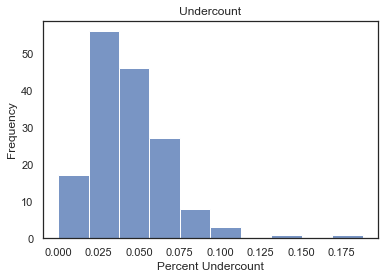

In [13]:
sns.histplot(data = df_gavote, x = 'relative_undercount', bins = 10)
plt.title('Undercount')
plt.xlabel('Percent Undercount')
plt.ylabel('Frequency');

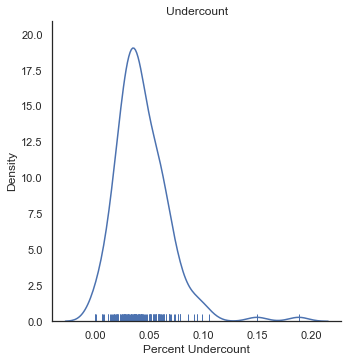

In [14]:
sns.displot(data = df_gavote, x = 'relative_undercount', rug = True, kind = 'kde')
plt.title('Undercount')
plt.xlabel('Percent Undercount');

In [15]:
df_gavote['equip'].value_counts()

LEVER    74
OS-CC    44
OS-PC    22
PUNCH    17
PAPER     2
Name: equip, dtype: int64

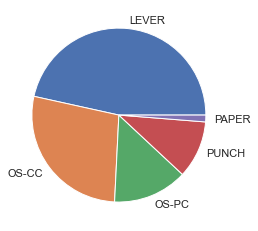

In [16]:
plt.pie(x = df_gavote['equip'].value_counts(), labels=df_gavote['equip'].unique());

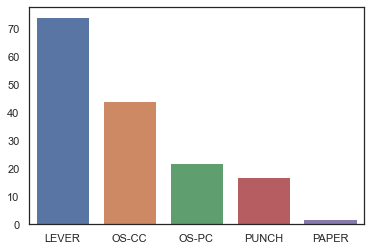

In [17]:
sns.countplot(data = df_gavote, x = 'equip', order = df_gavote['equip'].value_counts().index)
plt.ylabel('')
plt.xlabel('');

In [18]:
df_gavote['pergore'] = df_gavote['gore']/df_gavote['votes']

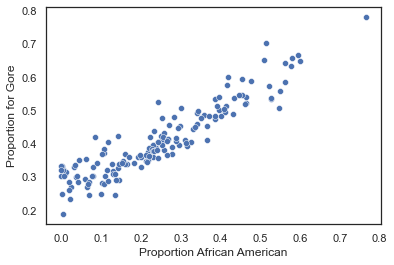

In [19]:
#Let’s see how the proportion voting for Gore relates to the proportion of African Americans:
sns.scatterplot(data = df_gavote, x = 'perAA', y = 'pergore')
plt.xlabel('Proportion African American')
plt.ylabel('Proportion for Gore');

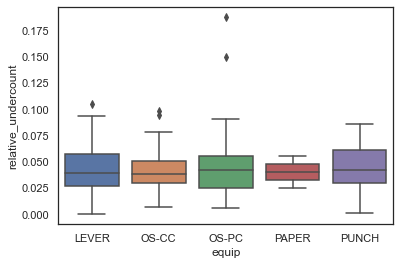

In [20]:
sns.boxplot(data = df_gavote, x = 'equip', y = 'relative_undercount');

In [21]:
df_gavote

,counties,equip,econ,perAA,rural,atlanta,gore,bush,other,votes,ballots,absolute_undercount,relative_undercount,pergore
0,APPLING,LEVER,poor,0.182,rural,notAtlanta,2093,3940,66,6099,6617,518,0.078283,0.343171
1,ATKINSON,LEVER,poor,0.230,rural,notAtlanta,821,1228,22,2071,2149,78,0.036296,0.396427
2,BACON,LEVER,poor,0.131,rural,notAtlanta,956,2010,29,2995,3347,352,0.105169,0.319199
3,BAKER,OS-CC,poor,0.476,rural,notAtlanta,893,615,11,1519,1607,88,0.054760,0.587887
4,BALDWIN,LEVER,middle,0.359,rural,notAtlanta,5893,6041,192,12126,12785,659,0.051545,0.485981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,WHITFIELD,OS-PC,rich,0.040,rural,notAtlanta,7034,15852,416,23302,23854,552,0.023141,0.301863
155,WILCOX,LEVER,poor,0.265,rural,notAtlanta,962,1381,22,2365,2430,65,0.026749,0.406765
156,WILKES,LEVER,middle,0.386,rural,notAtlanta,1940,2044,42,4026,4136,110,0.026596,0.481868
157,WILKINSON,LEVER,poor,0.408,rural,notAtlanta,1884,1800,56,3740,3792,52,0.013713,0.503743


In [22]:
df_gavote[['perAA','ballots','relative_undercount','pergore']].corr()

,perAA,ballots,relative_undercount,pergore
perAA,1.000000,0.027732,0.229687,0.921652
ballots,0.027732,1.000000,-0.155172,0.095617
relative_undercount,0.229687,-0.155172,1.000000,0.218765
pergore,0.921652,0.095617,0.218765,1.000000


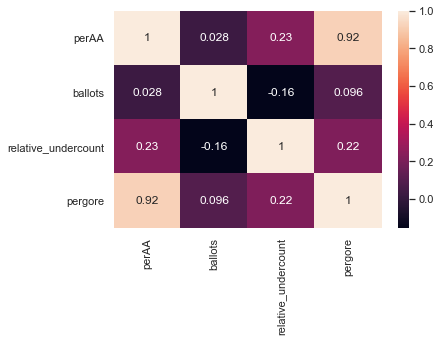

In [23]:
sns.heatmap(df_gavote[['perAA','ballots','relative_undercount','pergore']].corr(), annot=True);

<h2> Fitting a linear model: </h2>

In [24]:
import statsmodels.formula.api as smf 

In [25]:
df_gavote.head()

,counties,equip,econ,perAA,rural,atlanta,gore,bush,other,votes,ballots,absolute_undercount,relative_undercount,pergore
0,APPLING,LEVER,poor,0.182,rural,notAtlanta,2093,3940,66,6099,6617,518,0.078283,0.343171
1,ATKINSON,LEVER,poor,0.230,rural,notAtlanta,821,1228,22,2071,2149,78,0.036296,0.396427
2,BACON,LEVER,poor,0.131,rural,notAtlanta,956,2010,29,2995,3347,352,0.105169,0.319199
3,BAKER,OS-CC,poor,0.476,rural,notAtlanta,893,615,11,1519,1607,88,0.054760,0.587887
4,BALDWIN,LEVER,middle,0.359,rural,notAtlanta,5893,6041,192,12126,12785,659,0.051545,0.485981


In [26]:
lmod = smf.ols(data = df_gavote, formula = 'relative_undercount~pergore+perAA').fit()

In [27]:
lmod.params

Intercept    0.032376
pergore      0.010979
perAA        0.028533
dtype: float64

In [28]:
lmod.predict()

array([0.04133661, 0.04329088, 0.03961823, 0.05241202, 0.04795484,
       0.03601558, 0.03794768, 0.03824856, 0.0456844 , 0.03951183,
       0.0491883 , 0.0408404 , 0.0367021 , 0.04716214, 0.03946337,
       0.04272642, 0.05136792, 0.04401044, 0.05485224, 0.04179928,
       0.04344251, 0.03976103, 0.03602163, 0.04292433, 0.04750227,
       0.04764892, 0.03942706, 0.03555377, 0.04504196, 0.05549852,
       0.05405937, 0.04421053, 0.04099018, 0.04394917, 0.04171247,
       0.0379354 , 0.04412875, 0.03966886, 0.04419461, 0.04611705,
       0.03605864, 0.0351185 , 0.0466983 , 0.05475324, 0.04331231,
       0.05151597, 0.05358825, 0.04115587, 0.04775781, 0.03789845,
       0.03881787, 0.04444902, 0.04584928, 0.04515983, 0.03598472,
       0.03833868, 0.03963718, 0.03451702, 0.03800347, 0.05058744,
       0.03569792, 0.03705342, 0.04223991, 0.03694448, 0.04373769,
       0.04733356, 0.03915798, 0.03575577, 0.03718296, 0.06279187,
       0.03751672, 0.04064671, 0.04107793, 0.03930191, 0.03963

In [29]:
lmod.resid

0      0.036947
1     -0.006995
2      0.065551
3      0.002348
4      0.003590
         ...   
154   -0.013691
155   -0.017654
156   -0.022084
157   -0.035835
158    0.017498
Length: 159, dtype: float64

In [30]:
RMSE = np.sqrt(lmod.mse_resid)
RMSE

0.02444894961429212

In [31]:
R_Squared = lmod.rsquared
R_Squared

0.05308860901036749

In [32]:
Adj_R_Squared = lmod.rsquared_adj
Adj_R_Squared

0.04094871938229527

In [33]:
lmod.resid.describe()

count    1.590000e+02
mean    -1.023378e-17
std      2.429372e-02
min     -4.601315e-02
25%     -1.499534e-02
50%     -3.538550e-03
75%      1.178373e-02
max      1.424361e-01
dtype: float64

In [34]:
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     relative_undercount   R-squared:                       0.053
Model:                             OLS   Adj. R-squared:                  0.041
Method:                  Least Squares   F-statistic:                     4.373
Date:                 Fri, 03 Jun 2022   Prob (F-statistic):             0.0142
Time:                         23:52:51   Log-Likelihood:                 365.98
No. Observations:                  159   AIC:                            -726.0
Df Residuals:                      156   BIC:                            -716.8
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0324      0.013      2.537      0.012       0.007       0.058
pergore        0.0110      0.047      0.234      0.815      -0.082       0.104
perAA          0.0285      0.031      0.928      0.355      -0.032       0.089
==============================================================================
Omnibus:                       83.197   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              474.440
Skew:                           1.849   Prob(JB):                    9.47e-104
Kurtosis:                      10.612   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h2> Qualitative predictors: </h2>

In [35]:
df_gavote.head()

,counties,equip,econ,perAA,rural,atlanta,gore,bush,other,votes,ballots,absolute_undercount,relative_undercount,pergore
0,APPLING,LEVER,poor,0.182,rural,notAtlanta,2093,3940,66,6099,6617,518,0.078283,0.343171
1,ATKINSON,LEVER,poor,0.230,rural,notAtlanta,821,1228,22,2071,2149,78,0.036296,0.396427
2,BACON,LEVER,poor,0.131,rural,notAtlanta,956,2010,29,2995,3347,352,0.105169,0.319199
3,BAKER,OS-CC,poor,0.476,rural,notAtlanta,893,615,11,1519,1607,88,0.054760,0.587887
4,BALDWIN,LEVER,middle,0.359,rural,notAtlanta,5893,6041,192,12126,12785,659,0.051545,0.485981


In [36]:
df_gavote['cperAA'] = df_gavote['perAA']-np.mean(df_gavote['perAA'])

In [37]:
df_gavote['cpergore'] = df_gavote['pergore']-np.mean(df_gavote['pergore'])

In [38]:
lmodi = smf.ols(data = df_gavote, formula = 'relative_undercount~cperAA+cpergore*rural+equip').fit()

In [39]:
lmodi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     relative_undercount   R-squared:                       0.170
Model:                             OLS   Adj. R-squared:                  0.125
Method:                  Least Squares   F-statistic:                     3.829
Date:                 Fri, 03 Jun 2022   Prob (F-statistic):           0.000400
Time:                         23:53:00   Log-Likelihood:                 376.42
No. Observations:                  159   AIC:                            -734.8
Df Residuals:                      150   BIC:                            -707.2
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0433      0.003     15.253      0.000       0.038       0.049
rural[T.urban]             -0.0186      0.005     -4.009      0.000      -0.028      -0.009
equip[T.OS-CC]              0.0065      0.005      1.385      0.168      -0.003       0.016
equip[T.OS-PC]              0.0156      0.006      2.684      0.008       0.004       0.027
equip[T.PAPER]             -0.0091      0.017     -0.537      0.592      -0.043       0.024
equip[T.PUNCH]              0.0141      0.007      2.086      0.039       0.001       0.028
cperAA                      0.0283      0.031      0.909      0.365      -0.033       0.090
cpergore                    0.0082      0.051      0.161      0.872      -0.093       0.109
cpergore:rural[T.urban]    -0.0088      0.039     -0.227      0.821      -0.085       0.068
==============================================================================
Omnibus:                       68.825   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.731
Skew:                           1.534   Prob(JB):                     1.86e-71
Kurtosis:                       9.305   Cond. No.                         36.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h2> Hypothesis testing: </h2>

In [40]:
from scipy.stats import f_oneway

In [41]:
f_oneway(lmod.params, lmodi.params)

F_onewayResult(statistic=1.563064964368947, pvalue=0.23968148785972623)

In [42]:
import statsmodels.api as sm

In [43]:
#H0 : lmod is a better model than lmodi
#Ha : lmod is not a better model than lmodi
sm.stats.anova_lm(lmod, lmodi)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,156.0,0.093249,0.0,NaN,NaN,NaN
1,150.0,0.081775,6.0,0.011474,3.50769,0.002823


In [44]:
sm.stats.anova_lm(lmodi)

,df,sum_sq,mean_sq,F,PR(>F)
rural,1.0,0.007706,0.007706,14.135706,0.000243
equip,4.0,0.005295,0.001324,2.428129,0.050300
cperAA,1.0,0.003670,0.003670,6.732168,0.010408
cpergore,1.0,0.000002,0.000002,0.003799,0.950934
cpergore:rural,1.0,0.000028,0.000028,0.051657,0.820515
Residual,150.0,0.081775,0.000545,NaN,NaN


<h2> Confidence intervals </h2>

In [45]:
lmodi.conf_int()

,0,1
Intercept,0.037688,0.048906
rural[T.urban],-0.027821,-0.009452
equip[T.OS-CC],-0.002765,0.015730
equip[T.OS-PC],0.004125,0.027154
equip[T.PAPER],-0.042537,0.024353
equip[T.PUNCH],0.000748,0.027551
cperAA,-0.033171,0.089699
cpergore,-0.092843,0.109317
cpergore:rural[T.urban],-0.085299,0.067700


<h2> Diagnostics </h2>

In [46]:
y_pred = lmodi.predict()

In [47]:
residuals = lmodi.resid

In [48]:
stand_residuals = lmodi.resid_pearson

In [59]:
type(stand_residuals)

numpy.ndarray

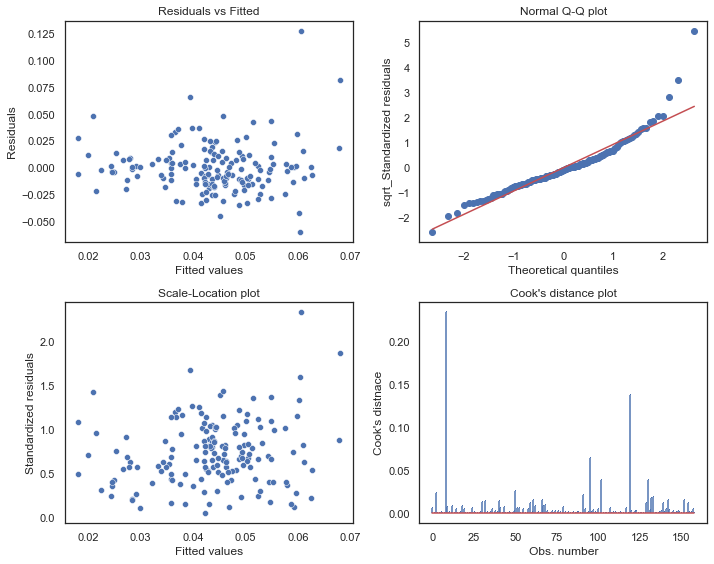

In [60]:
fig, axes = plt.subplots(2,2, figsize = (10,8))
sns.scatterplot(x = y_pred, y = residuals, ax =axes[0,0])
axes[0,0].set_title('Residuals vs Fitted')
axes[0,0].set_xlabel('Fitted values')
axes[0,0].set_ylabel('Residuals')

import scipy as sp
sp.stats.probplot(x = stand_residuals, plot = axes[0,1], fit = False)
axes[0,1].set_title('Normal Q-Q plot')
axes[0,1].set_ylabel('sqrt_Standardized residuals')

sns.scatterplot(x = y_pred, y = np.sqrt(abs(stand_residuals)), ax =axes[1,0])
axes[1,0].set_title('Scale-Location plot')
axes[1,0].set_ylabel('Standardized residuals')
axes[1,0].set_xlabel('Fitted values')


from statsmodels.stats.outliers_influence import OLSInfluence as influence
inf = influence(lmodi)
C, P = inf.cooks_distance
axes[1,1].stem(C, markerfmt=",")
axes[1,1].set_title("Cook's distance plot")
axes[1,1].set_xlabel('Obs. number')
axes[1,1].set_ylabel("Cook's distnace")


plt.tight_layout();

<h2> Weighted least squares:

In [59]:
df_gavote.head()

,counties,equip,econ,perAA,rural,atlanta,gore,bush,other,votes,ballots,absolute_undercount,relative_undercount,pergore,cperAA,cpergore
0,APPLING,LEVER,poor,0.182,rural,notAtlanta,2093,3940,66,6099,6617,518,0.078283,0.343171,-0.060981,-0.065151
1,ATKINSON,LEVER,poor,0.230,rural,notAtlanta,821,1228,22,2071,2149,78,0.036296,0.396427,-0.012981,-0.011895
2,BACON,LEVER,poor,0.131,rural,notAtlanta,956,2010,29,2995,3347,352,0.105169,0.319199,-0.111981,-0.089123
3,BAKER,OS-CC,poor,0.476,rural,notAtlanta,893,615,11,1519,1607,88,0.054760,0.587887,0.233019,0.179565
4,BALDWIN,LEVER,middle,0.359,rural,notAtlanta,5893,6041,192,12126,12785,659,0.051545,0.485981,0.116019,0.077659


In [120]:
wlmodi = smf.wls(data = df_gavote, formula = 'relative_undercount~cperAA+cpergore*rural+equip', weights = np.array(df_gavote['ballots'])).fit()

In [121]:
wlmodi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             WLS Regression Results                            
===============================================================================
Dep. Variable:     relative_undercount   R-squared:                       0.410
Model:                             WLS   Adj. R-squared:                  0.378
Method:                  Least Squares   F-statistic:                     13.02
Date:                 Thu, 24 Mar 2022   Prob (F-statistic):           3.67e-14
Time:                         05:37:34   Log-Likelihood:                 364.72
No. Observations:                  159   AIC:                            -711.4
Df Residuals:                      150   BIC:                            -683.8
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0437      0.003     12.689      0.000       0.037       0.050
rural[T.urban]             -0.0179      0.004     -4.815      0.000      -0.025      -0.011
equip[T.OS-CC]              0.0056      0.005      1.201      0.232      -0.004       0.015
equip[T.OS-PC]             -0.0058      0.005     -1.242      0.216      -0.015       0.003
equip[T.PAPER]             -0.0142      0.037     -0.380      0.705      -0.088       0.060
equip[T.PUNCH]              0.0157      0.005      2.913      0.004       0.005       0.026
cperAA                      0.0681      0.028      2.473      0.015       0.014       0.123
cpergore                   -0.0469      0.053     -0.889      0.375      -0.151       0.057
cpergore:rural[T.urban]     0.0120      0.036      0.337      0.737      -0.058       0.082
==============================================================================
Omnibus:                       55.024   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              266.937
Skew:                           1.160   Prob(JB):                     1.08e-58
Kurtosis:                       8.909   Cond. No.                         65.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
np.sqrt(0.035*(1-0.035)/881)

0.006191697417719903

<h2> Transformation

In [95]:
from sklearn.preprocessing import PolynomialFeatures

In [125]:
poly_trans = PolynomialFeatures(degree=4)

In [126]:
poly_cperAA = poly_trans.fit_transform(np.array(df_gavote['cperAA']).reshape(-1,1))

In [127]:
plmodi = smf.ols(data = df_gavote, formula = 'relative_undercount~poly_cperAA+cpergore*rural+equip').fit()

In [128]:
plmodi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     relative_undercount   R-squared:                       0.173
Model:                             OLS   Adj. R-squared:                  0.111
Method:                  Least Squares   F-statistic:                     2.788
Date:                 Thu, 24 Mar 2022   Prob (F-statistic):            0.00254
Time:                         05:40:44   Log-Likelihood:                 376.71
No. Observations:                  159   AIC:                            -729.4
Df Residuals:                      147   BIC:                            -692.6
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0215      0.002     12.590      0.000       0.018       0.025
rural[T.urban]             -0.0191      0.005     -4.035      0.000      -0.028      -0.010
equip[T.OS-CC]              0.0064      0.005      1.364      0.175      -0.003       0.016
equip[T.OS-PC]              0.0156      0.006      2.652      0.009       0.004       0.027
equip[T.PAPER]             -0.0103      0.017     -0.597      0.551      -0.044       0.024
equip[T.PUNCH]              0.0141      0.007      2.047      0.042       0.000       0.028
poly_cperAA[0]              0.0215      0.002     12.590      0.000       0.018       0.025
poly_cperAA[1]              0.0125      0.047      0.268      0.789      -0.079       0.104
poly_cperAA[2]              0.0545      0.112      0.486      0.628      -0.167       0.276
poly_cperAA[3]              0.3226      0.632      0.510      0.611      -0.927       1.572
poly_cperAA[4]             -0.8860      1.298     -0.682      0.496      -3.452       1.680
cpergore                    0.0132      0.057      0.231      0.818      -0.099       0.126
cpergore:rural[T.urban]    -0.0105      0.041     -0.255      0.799      -0.092       0.071
==============================================================================
Omnibus:                       68.711   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.174
Skew:                           1.528   Prob(JB):                     9.02e-72
Kurtosis:                       9.328   Cond. No.                     2.52e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.49e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<h2> Variable selection: </h2>

In [133]:
biglm = smf.ols(data=df_gavote, formula = '(relative_undercount ~ (equip+econ+rural+atlanta)**2+(equip+econ+rural+atlanta)*(perAA+pergore))').fit()

In [138]:
biglm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     relative_undercount   R-squared:                       0.504
Model:                             OLS   Adj. R-squared:                  0.335
Method:                  Least Squares   F-statistic:                     2.994
Date:                 Thu, 24 Mar 2022   Prob (F-statistic):           2.36e-06
Time:                         05:56:42   Log-Likelihood:                 417.34
No. Observations:                  159   AIC:                            -752.7
Df Residuals:                      118   BIC:                            -626.9
Df Model:                           40                                         
Covariance Type:             nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.0626      0.094      0.666      0.507      -0.124       0.249
equip[T.OS-CC]                           0.0377      0.049      0.769      0.443      -0.059       0.135
equip[T.OS-PC]                          -0.0733      0.055     -1.326      0.187      -0.183       0.036
equip[T.PAPER]                          -0.0228      0.015     -1.500      0.136      -0.053       0.007
equip[T.PUNCH]                          -0.0122      0.058     -0.212      0.832      -0.126       0.102
econ[T.poor]                             0.0110      0.017      0.636      0.526      -0.023       0.045
econ[T.rich]                            -0.0807      0.142     -0.568      0.571      -0.362       0.201
rural[T.urban]                          -0.0048      0.053     -0.091      0.928      -0.110       0.100
atlanta[T.notAtlanta]                   -0.0312      0.091     -0.342      0.733      -0.212       0.149
equip[T.OS-CC]:econ[T.poor]             -0.0113      0.011     -1.040      0.301      -0.033       0.010
equip[T.OS-PC]:econ[T.poor]              0.0303      0.017      1.801      0.074      -0.003       0.064
equip[T.PAPER]:econ[T.poor]             -0.0228      0.015     -1.500      0.136      -0.053       0.007
equip[T.PUNCH]:econ[T.poor]              0.0139      0.032      0.435      0.664      -0.049       0.077
equip[T.OS-CC]:econ[T.rich]              0.0152      0.040      0.384      0.701      -0.063       0.094
equip[T.OS-PC]:econ[T.rich]              0.0239      0.030      0.808      0.421      -0.035       0.083
equip[T.PAPER]:econ[T.rich]           2.317e-16   3.78e-16      0.613      0.541   -5.17e-16     9.8e-16
equip[T.PUNCH]:econ[T.rich]              0.0219      0.040      0.553      0.581      -0.056       0.100
equip[T.OS-CC]:rural[T.urban]            0.0004      0.012      0.033      0.973      -0.024       0.024
equip[T.OS-PC]:rural[T.urban]           -0.0114      0.017     -0.661      0.510      -0.046       0.023
equip[T.PAPER]:rural[T.urban]         5.713e-17   5.16e-16      0.111      0.912   -9.66e-16    1.08e-15
equip[T.PUNCH]:rural[T.urban]            0.0399      0.028      1.432      0.155      -0.015       0.095
equip[T.OS-CC]:atlanta[T.notAtlanta]    -0.0496      0.040     -1.244      0.216      -0.128       0.029
equip[T.OS-PC]:atlanta[T.notAtlanta]    -0.0413      0.046     -0.901      0.369      -0.132       0.049
equip[T.PAPER]:atlanta[T.notAtlanta]    -0.0228      0.015     -1.500      0.136      -0.053       0.007
equip[T.PUNCH]:atlanta[T.notAtlanta]    -0.0507      0.040     -1.255      0.212      -0.131       0.029
econ[T.poor]:rural[T.urban]             -0.0173      0.019     -0.895      0.372      -0.056       0.021
econ[T.rich]:rural[T.urban]